In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.diagnostics import ProgressBar
from geocube.api.core import make_geocube

PATH = "D:\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"

PARQUET_PATH = rf"{DATA_PROC}/shocks_by_adm"


c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_yearly.nc")
ds

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


<xarray.Dataset> Size: 13GB
Dimensions:      (y: 1799, x: 3600, year: 51)
Coordinates:
  * x            (x) float64 29kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * y            (y) float32 7kB 89.9 89.8 89.7 89.6 ... -89.6 -89.7 -89.8 -89.9
  * year         (year) int64 408B 1970 1971 1972 1973 ... 2017 2018 2019 2020
Data variables: (12/40)
    SPI1_10sd    (y, x, year) bool 330MB ...
    SPI1_15sd    (y, x, year) bool 330MB ...
    SPI1_20sd    (y, x, year) bool 330MB ...
    SPI1_25sd    (y, x, year) bool 330MB ...
    SPEI1_10sd   (y, x, year) bool 330MB ...
    SPEI1_15sd   (y, x, year) bool 330MB ...
    ...           ...
    SPI24_20sd   (y, x, year) bool 330MB ...
    SPI24_25sd   (y, x, year) bool 330MB ...
    SPEI24_10sd  (y, x, year) bool 330MB ...
    SPEI24_15sd  (y, x, year) bool 330MB ...
    SPEI24_20sd  (y, x, year) bool 330MB ...
    SPEI24_25sd  (y, x, year) bool 330MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-11 19:34:49 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63948,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.88 GiB
Comm: tcp://127.0.0.1:63967,Total threads: 1
Dashboard: http://127.0.0.1:63970/status,Memory: 7.97 GiB
Nanny: tcp://127.0.0.1:63951,


In [3]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly_fixed.nc", chunks={"x":  17173//2+1, "y": 43200//2+1, "year":100})
ds["year"] = range(1970, 2021)

ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")
# ds.sel(x=slice(-80,-60), y=slice(30, 16), year=2008)["category_3_b10"].plot()
# ds.sel(x=slice(-55, -40), y=slice(-5, -25), year=2008)["SPEI-24"].plot(cmap="RdBu")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 8587. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


PermissionError: [Errno 13] Permission denied: 'D:\\World Bank\\CLIENT v2\\Data\\Data_out\\IBTrACS_hurricanes_yearly.nc'

In [40]:
ds

<xarray.Dataset> Size: 454GB
Dimensions:          (year: 51, y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B ...
  * year             (year) int32 204B 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    category_3_b10   (year, y, x) bool 38GB ...
    category_3_b100  (year, y, x) bool 38GB ...
    category_3_b25   (year, y, x) bool 38GB ...
    category_3_b50   (year, y, x) bool 38GB ...
    category_4_b10   (year, y, x) bool 38GB ...
    category_4_b100  (year, y, x) bool 38GB ...
    category_4_b25   (year, y, x) bool 38GB ...
    category_4_b50   (year, y, x) bool 38GB ...
    category_5_b10   (year, y, x) bool 38GB ...
    category_5_b100  (year, y, x) bool 38GB ...
    category_5_b25   (year, y, x) bool 38GB ...
    category_5_b50   (year, y, x) bool 38GB ...

In [14]:
ds

<xarray.Dataset> Size: 40GB
Dimensions:  (year: 51, y: 1799, x: 3600)
Coordinates:
  * x        (x) float64 29kB -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * y        (y) float32 7kB 89.9 89.8 89.7 89.6 ... -89.6 -89.7 -89.8 -89.9
  * year     (year) int64 408B 1970 1971 1972 1973 1974 ... 2017 2018 2019 2020
Data variables: (12/15)
    d2m      (year, y, x) float64 3GB ...
    t2m      (year, y, x) float64 3GB ...
    sp       (year, y, x) float64 3GB ...
    tp       (year, y, x) float64 3GB ...
    PET      (y, x, year) float64 3GB ...
    SPI-1    (y, x, year) float64 3GB ...
    ...       ...
    SPI-6    (y, x, year) float64 3GB ...
    SPEI-6   (y, x, year) float64 3GB ...
    SPI-12   (y, x, year) float64 3GB ...
    SPEI-12  (y, x, year) float64 3GB ...
    SPI-24   (y, x, year) float64 3GB ...
    SPEI-24  (y, x, year) float64 3GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-11 19:34:49 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

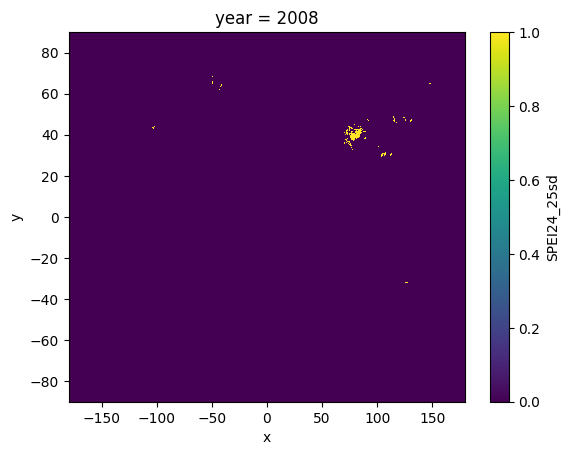

In [11]:
ds["SPEI24_25sd"].sel(year=2008).plot()

In [4]:
ds.sel(year=2008).to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\ERA5_droughts_2008.nc", encoding={col: {"zlib":True, "complevel": 9} for col in ds.data_vars})

In [3]:
gpd.read_feather(rf"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")

,ID,OBJECTID,ADM2_CODE,ADM1_CODE,ADM0_CODE,geometry
0,0,37101.0,0.0,334,3,"POLYGON ((20.05039 39.76022, 20.05071 39.75933..."
1,1,38216.0,0.0,389,5,"MULTIPOLYGON (((-170.83611 -14.32552, -170.835..."
2,2,36057.0,0.0,391,7,"POLYGON ((1.56639 42.47614, 1.55510 42.47741, ..."
3,3,36058.0,0.0,392,7,"POLYGON ((1.78038 42.57164, 1.77521 42.57164, ..."
4,4,36059.0,0.0,393,7,"POLYGON ((1.74447 42.56623, 1.74261 42.56584, ..."
...,...,...,...,...,...,...
38145,38145,5781.0,191421.0,2218,182,"MULTIPOLYGON (((6.27344 5.46275, 6.27755 5.460..."
38146,38146,5782.0,191422.0,2231,182,"MULTIPOLYGON (((6.11198 9.09892, 6.11325 9.098..."
38147,38147,5783.0,191423.0,2240,182,"MULTIPOLYGON (((11.20148 12.49003, 11.20060 12..."
38148,38148,5784.0,191424.0,65710,182,"MULTIPOLYGON (((6.36416 11.84449, 6.36371 11.8..."


In [2]:
df = pd.read_csv(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\WB\drought_wide.csv", nrows=1000)
df

,Unnamed: 0,ID,year,spei12_10sd_p,spei12_15sd_p,spei12_20sd_p,spei12_25sd_p,spei1_10sd_p,spei1_15sd_p,spei1_20sd_p,...,spi24_20sd_a,spi24_25sd_a,spi3_10sd_a,spi3_15sd_a,spi3_20sd_a,spi3_25sd_a,spi6_10sd_a,spi6_15sd_a,spi6_20sd_a,spi6_25sd_a
0,0,0,1970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,1972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,1973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,1974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,20,1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,996,20,1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,997,20,1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,998,20,1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import xarray as xr
import utils
import geopandas as gpd
WB_data = gpd.read_feather(r"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_country_grid.nc")
for i in range(16):
    datafilter, chunk_bounds = utils.get_filter_from_chunk_number(
        i, total_chunks=16, canvas=WB_data.total_bounds
    )
    print(datafilter)
ds

{'x': slice(-179.99999999990004, -89.99999999990001, None), 'y': slice(-23.706354845399773, -59.48427929994972, None)}
{'x': slice(-179.99999999990004, -89.99999999990001, None), 'y': slice(12.071569609150174, -23.706354845399773, None)}
{'x': slice(-179.99999999990004, -89.99999999990001, None), 'y': slice(47.84949406370012, 12.071569609150174, None)}
{'x': slice(-179.99999999990004, -89.99999999990001, None), 'y': slice(83.62741851825007, 47.84949406370012, None)}
{'x': slice(-89.99999999990001, 1.000159954855917e-10, None), 'y': slice(-23.706354845399773, -59.48427929994972, None)}
{'x': slice(-89.99999999990001, 1.000159954855917e-10, None), 'y': slice(12.071569609150174, -23.706354845399773, None)}
{'x': slice(-89.99999999990001, 1.000159954855917e-10, None), 'y': slice(47.84949406370012, 12.071569609150174, None)}
{'x': slice(-89.99999999990001, 1.000159954855917e-10, None), 'y': slice(83.62741851825007, 47.84949406370012, None)}
{'x': slice(1.000159954855917e-10, 90.000000000100

<xarray.Dataset> Size: 6GB
Dimensions:  (y: 17173, x: 43200)
Coordinates:
  * y        (y) float64 137kB 83.62 83.61 83.6 83.6 ... -59.46 -59.47 -59.48
  * x        (x) float64 346kB -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    ID       (y, x) float64 6GB ...

In [34]:
import pandas as pd
import geopandas as gpd

gdf = gpd.read_feather(r"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")
gdf = gdf.drop(columns=["OBJECTID", "geometry"])
gdf.columns = gdf.columns.str.lower()
gdf = gdf.rename({"id":"ID"})

for shock in ["drought", "floods", "hurricanes"]:
    df = pd.read_csv(rf"D:\World Bank\CLIENT v2\Data\Data_out\WB_{shock}_long.csv")

    dflong = df.drop(columns=["Unnamed: 0", "chunk"]).melt(id_vars=["ID", "year", "variable", "threshold"], var_name="measure", value_name="value")
    print(dflong.measure.unique())
    dflong = gdf.merge(dflong, on="ID", validate="1:m").drop(columns=["ID"]) 
    dflong.to_csv(rf"D:\World Bank\CLIENT v2\Data\Data_out\for webpage\WB_{shock}.csv")

In [32]:
dflong

,year,variable,threshold,measure,value,ADM2_CODE,ADM1_CODE,ADM0_CODE
0,1970,category 3,b10,area_affected,0.0,0.0,334,3
1,1970,category 3,b100,area_affected,0.0,0.0,334,3
2,1970,category 3,b25,area_affected,0.0,0.0,334,3
3,1970,category 3,b50,area_affected,0.0,0.0,334,3
4,1970,category 4,b10,area_affected,0.0,0.0,334,3
...,...,...,...,...,...,...,...,...
46650307,2020,category 4,b50,population_affected,0.0,191425.0,2212,182
46650308,2020,category 5,b10,population_affected,0.0,191425.0,2212,182
46650309,2020,category 5,b100,population_affected,0.0,191425.0,2212,182
46650310,2020,category 5,b25,population_affected,0.0,191425.0,2212,182


In [12]:
chunk_adm_id = ds.sel({'x': slice(-179.99999999990004, -89.99999999990001, None), 'y': slice(-23.706354845399773, -59.48427929994972)}).ID
chunk_adm_id = chunk_adm_id.load()

(chunk_adm_id.fillna(99999) != 99999).sum()

<xarray.DataArray 'ID' ()> Size: 4B
array(225)

In [2]:
import utils
from tqdm import tqdm
shockname = "drought"
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [3]:
import geopandas as gpd

gdf = gpd.read_file(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.list.v04r01.lines.shp")

In [22]:
import xarray as xr

ds = xr.open_dataset(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.v04r01.nc", chunks={"storm": 1})
ds

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "storm" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 4GB
Dimensions:           (storm: 13353, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] 38MB dask.array<chunksize=(1, 360), meta=np.ndarray>
    lat               (storm, date_time) float32 19MB dask.array<chunksize=(1, 360), meta=np.ndarray>
    lon               (storm, date_time) float32 19MB dask.array<chunksize=(1, 360), meta=np.ndarray>
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/159)
    numobs            (storm) float32 53kB dask.array<chunksize=(1,), meta=np.ndarray>
    sid               (storm) |S13 174kB dask.array<chunksize=(1,), meta=np.ndarray>
    season            (storm) float32 53kB dask.array<chunksize=(1,), meta=np.ndarray>
    number            (storm) int16 27kB dask.array<chunksize=(1,), meta=np.ndarray>
    basin             (storm, date_time) |S2 10MB dask.array<chunksize=(1, 306), meta=np.ndarray>
    subbasin          (storm, date_time) |S2 10MB dask.array<chunksize=(1, 306), meta=np.ndarray>
    ...                ...
    reunion_gust      (storm, date_time) float32 19MB dask.array<chunksize=(1, 360), meta=np.ndarray>
    reunion_gust_per  (storm, date_time) float32 19MB dask.array<chunksize=(1, 360), meta=np.ndarray>
    usa_seahgt        (storm, date_time) float32 19MB dask.array<chunksize=(1, 360), meta=np.ndarray>
    usa_searad        (storm, date_time, quadrant) float32 77MB dask.array<chunksize=(1, 217, 2), meta=np.ndarray>
    storm_speed       (storm, date_time) float32 19MB dask.array<chunksize=(1, 360), meta=np.ndarray>
    storm_dir         (storm, date_time) float32 19MB dask.array<chunksize=(1, 360), meta=np.ndarray>
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Tue Jul  2 06:44:42 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

In [23]:
from dask.diagnostics import ProgressBar
ds = ds.where(ds.storm.isin(storms))

with ProgressBar():
    ds = ds.compute()

[                                        ] | 0% Completed | 189.69 ss


KeyboardInterrupt: 

In [17]:
import numpy as np
storms = np.argwhere((ds.season == 1983).values).flatten()
storms

array([8895, 8955, 8956, 8958, 8963, 8966, 8967, 8968, 8969, 8970, 8971,
       8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982,
       8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993,
       8994, 8995, 8996, 8997, 8998, 8999, 9001, 9002, 9003, 9004, 9005,
       9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016,
       9017, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027,
       9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038,
       9039, 9040, 9041, 9042, 9043, 9045, 9046, 9047, 9048, 9049, 9051,
       9052, 9053, 9055, 9057, 9058, 9061, 9062, 9065], dtype=int64)

In [3]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61799,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:61824,Total threads: 1
Dashboard: http://127.0.0.1:61827/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:61802,


In [4]:
import numpy as np
import os

files = os.listdir(PARQUET_PATH)
files = [f for f in files if f.endswith(".parquet") and "drought" in f]

def func(partition, partition_info=None):
    try:
        return str(files[partition_info["number"]])
    except:
        print("No info")
        return ""

df = dd.read_parquet(os.path.join(PARQUET_PATH, "drought_*.parquet"))
df["filename"] = ""
df["filename"] = df["filename"].astype(str)
df["filename"] = df["filename"].map_partitions(func, enforce_metadata=True)
df["cells_affected"] = df["cells_affected"].fillna(0).astype(np.uint32)
df["total_cells"] = df["total_cells"].fillna(0).astype(np.uint32)
df["population_affected_n"] = df["population_affected_n"].fillna(0).astype(np.uint64)
df["total_population"] = df["total_population"].fillna(0).astype(np.uint64)

No info


In [17]:
import pandas as pd
df = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\drought_SPI24_25sd_2008_14_zonal_stats.parquet")
df

,cells_affected,total_cells,population_affected_n,total_population
128,NaN,1358,NaN,5.964309e+06
200,NaN,660,NaN,1.549342e+05
391,NaN,21,NaN,2.757014e+05
479,NaN,8,NaN,NaN
537,NaN,564,NaN,4.887228e+04
...,...,...,...,...
36805,1331.0,3919,4639.969355,1.498567e+04
36806,1710.0,6323,416.310517,1.875786e+03
36807,NaN,4447,NaN,3.275058e+03
36808,NaN,4006,NaN,4.117103e+03


In [16]:
import importlib
importlib.reload(utils)

<module 'utils' from 'd:\\World Bank\\CLIENT v2\\utils.py'>

In [29]:
import pandas as pd
import utils
import os
import numpy as np
import geopandas as gpd

path = r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\WB"
f = f"WB_drought_SPI3_10sd_1987_2_zonal_stats.parquet"
shockname = "drought"
df = pd.read_parquet(os.path.join(path, f))
df = utils.compress_dataframe(df)
names = utils.parse_filename(f, shockname)
for col, value in names.items():
    df[col] = value
df = utils.process_chunk(df)


df = df.groupby(["ID", "name", "year"]).sum()
df["area_affected"] = df["cells_affected"] / df["total_cells"]
df["population_affected"] = df["population_affected_n"] / df["total_population"]
df = (
    df.drop(
        columns=[
            "cells_affected",
            "total_cells",
            "population_affected_n",
            "total_population",
        ]
    )
    .reset_index()
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)


pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)


# Reindex the two-level columns pivot returns
newcols = []
for cols in pivot.columns:
    newcols += [utils.parse_columns(cols)]
pivot.columns = newcols
pivot = pivot.reset_index()

gdf = gpd.read_feather(r"D:\World Bank\CLIENT v2\Data\Data_proc\WB_country_IDs.feather")
out_df = gdf.merge(pivot, on="ID", validate="1:m", how="inner")

out_df[
    ["ADM0_CODE", "ADM1_CODE", "ADM2_CODE", "year", "ID"] + newcols
].to_stata(f"WB_{shockname}_by_admlast_sampled.dta")


In [31]:
out_df[
    ["ADM0_CODE", "ADM1_CODE", "ADM2_CODE", "year", "ID"] + newcols
]

,ADM0_CODE,ADM1_CODE,ADM2_CODE,year,ID,spi3_10sd_p,spi3_10sd_a
0,129,1700,0.0,1987,240,0.000000,0.000000
1,164,2061,0.0,1987,413,0.000000,0.000000
2,75,1184,15572.0,1987,12145,0.997188,0.944444
3,75,1184,15573.0,1987,12146,0.847545,0.838174
4,75,1184,15576.0,1987,12149,1.000000,1.000000
...,...,...,...,...,...,...,...
3633,259,3219,154738.0,1987,37388,0.000000,0.000000
3634,259,3219,154739.0,1987,37389,0.000000,0.000000
3635,259,3219,154740.0,1987,37390,0.000000,0.000000
3636,259,3219,154741.0,1987,37391,0.000000,0.000000


In [32]:
import xarray as xr
xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 757GB
Dimensions:          (year: 51, y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B ...
  * year             (year) int32 204B 1970 1971 1972 1973 ... 2018 2019 2020
Data variables: (12/20)
    category_1_b10   (year, y, x) bool 38GB ...
    category_1_b100  (year, y, x) bool 38GB ...
    category_1_b25   (year, y, x) bool 38GB ...
    category_1_b50   (year, y, x) bool 38GB ...
    category_2_b10   (year, y, x) bool 38GB ...
    category_2_b100  (year, y, x) bool 38GB ...
    ...               ...
    category_4_b25   (year, y, x) bool 38GB ...
    category_4_b50   (year, y, x) bool 38GB ...
    category_5_b10   (year, y, x) bool 38GB ...
    category_5_b100  (year, y, x) bool 38GB ...
    category_5_b25   (year, y, x) bool 38GB ...
    category_5_b50   (year, y, x) bool 38GB ...

In [ ]:
# Concatenate all the dataframes and create the shock variables
df = dd.concat(dfs)
df = df.groupby(["ID", "name", "year"]).sum()
df["area_affected"] = df["cells_affected"] / df["total_cells"]
df["population_affected"] = df["population_affected_n"] / df["total_population"]
df = (
    df.drop(
        columns=[
            "cells_affected",
            "total_cells",
            "population_affected_n",
            "total_population",
        ]
    )
    .reset_index()
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)



In [1]:
import xarray as xr

#
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")

# Size in GB
ds["category_1_b10"].nbytes / 1e9 / 16

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


2.3647221

In [14]:
floods = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\GFD_floods_yearly.nc")
floods.sel(year=2007).to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\GFD_floods_2007.nc", encoding={"band_data":{"zlib":True, "complevel":6}})

In [ ]:
import xarray as xr

xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")

In [ ]:
path = os.path.join(PARQUET_PATH, f"{shockname}_long.csv")
df.to_csv(path, single_file=True)
print(f"Se creó {path}")

df = pd.read_csv(path)
# Pivot data: every shock has to be a column
pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)

# Reindex the two-level columns pivot returns
newcols = []
for cols in pivot.columns:
    newcols += [utils.parse_columns(cols)]
pivot.columns = newcols
pivot = pivot.reset_index()

path = os.path.join(PARQUET_PATH, f"{shockname}_wide.csv")
pivot.to_csv(path)
print(f"Se creó {path}")

pivot = pd.read_csv(path)

# Add the data to the gdf
out_df = gdf.merge(pivot, left_on="id", right_on="ID", validate="1:m", how="outer")


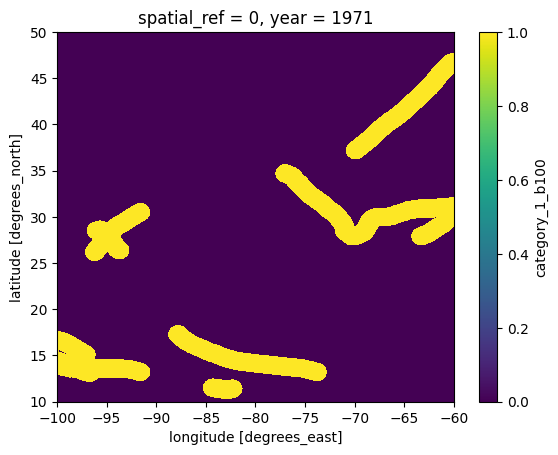

In [14]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_category_1_b100.nc")
# Select Florida
ds = ds.sel(y=slice(50, 10), x=slice(-100, -60))
ds["category_1_b100"].plot()

In [3]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_category_1_b100.nc", chunks={"x": 43200/10, "y": 17173//10})
# # Select Japan 120.937500,20.961441,149.589844,40.713957
# ds = ds.sel(y=slice(40.713957, 20.961441), x=slice(120.937500, 149.589844))
# ds["category_1_b100"].max()

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 1717. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 4320. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


[########################################] | 100% Completed | 10.24 ss


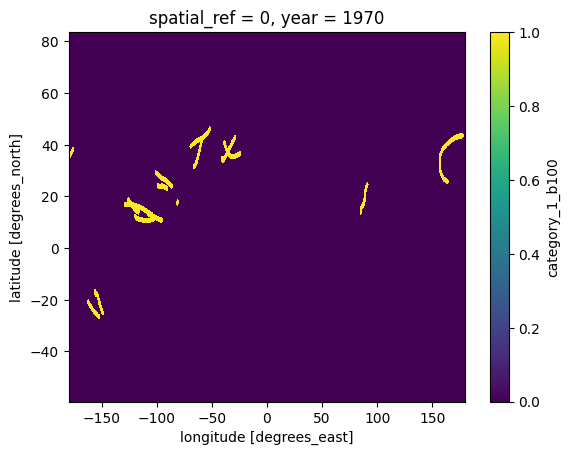

In [22]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    test = ds["category_1_b100"].coarsen(x=10, y=10, boundary="trim").max().plot()

In [11]:
ds.coarsen(x=10, y=10, boundary="pad").max()["category_1_b100"].max()

In [9]:
data = ["D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.25.nc"]

data2 = [
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1952_0.25.nc"
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1952_0.25.nc"
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1952_0.1.nc",
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1952_0.25.nc"
]
import xarray as xr
xr.open_mfdataset([data, data2], combine='nested', concat_dim="year")

ValueError: The supplied objects do not form a hypercube because sub-lists do not have consistent lengths along dimension 0

In [4]:
import pandas as pd
import dask.dataframe as dd
df = dd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_SPEI24_15sd_2020_15_zonal_stats.parquet")
df

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


,cells_affected,total_cells,population_affected_n,total_population
npartitions=1,,,,
,float64,int64,float64,float64
,...,...,...,...


In [33]:
import os
import xarray as xr
from dask.diagnostics import ProgressBar

path = r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes"
files = os.listdir(path)
dss = []
for year in range(1970, 2021):
    
    files_year = [os.path.join(path, f) for f in files if f"{year}" in f]
    dss += [xr.open_mfdataset(files_year)]
    
    if year==1975:
        break

ds = xr.concat(dss, dim="time")
with ProgressBar():
    ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_1975.nc")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 1717. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 4320. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 297GB
Dimensions:          (time: 20, y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B 0
    year             (time) int32 80B 1970 1971 1972 1973 ... 1987 1988 1989
Dimensions without coordinates: time
Data variables: (12/20)
    category_1_b10   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_1_b100  (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_1_b25   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_1_b50   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_2_b10   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_2_b100  (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    ...               ...
    category_4_b25   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_4_b50   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b10   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b100  (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b25   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b50   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>

In [32]:
dss[10]

<xarray.Dataset> Size: 15GB
Dimensions:          (y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B 0
    year             int32 4B 1980
Data variables: (12/20)
    category_1_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    ...               ...
    category_4_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_4_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>

In [24]:
import dask.dataframe as dd
df = pd.read_csv(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_long.csv")
pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)
pivot

,,population_affected,area_affected
,name,droughtSPEI-12,droughtSPEI-12
ID,year,,
0,1,0.000000,0.000000
1,1,0.000000,0.000000
2,1,0.000000,0.000000
3,1,0.000000,0.000000
4,1,0.000000,0.000000
...,...,...,...
38145,1,0.000000,0.000000
38146,1,0.000000,0.000000


In [28]:
xr.combine_by_coords(dss[1977])

<xarray.Dataset> Size: 15GB
Dimensions:          (y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B 0
    year             int32 4B 1977
Data variables: (12/20)
    category_1_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    ...               ...
    category_4_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_4_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>

In [7]:
repl = {"year":"y", "lat":"y"}

df.columns

AttributeError: 'Index' object has no attribute 'replace'

In [27]:
import utils



In [85]:
gdf = gpd.read_file(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.list.v04r01.lines.shp")#, "BASIN", "SUBBASIN", "NAME", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", "WMO_AGENCY", "TRACK_TYPE"])
gdf["WMO_WIND"] = gdf["WMO_WIND"].ffill()
gdf[gdf.SID == "2021323S10103"].explore(column="WMO_WIND")